# ML Lab 11 - LSTM for Air Polution Forecasting



**Objectives**: Apply Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) for 
Multivariate Time Series Forecasting. 

**The forecasting problem**: Air Quality dataset reports on the weather and the level of pollution each hour over 5 years at the US embassy in Beijing, China. Given the weather conditions and pollution for prior hours, forecast the pollution at the next hour.

Data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete list of data is as follows:

**Total data**: 43800 samples (5 years x 365 days x 24 hours), 8 features.

**year-month-day-hour**: date of data in this row

**pm2.5**: PM2.5 concentration  (**pollution indicator => the predicted variable**) 

**DEWP**: Dew Point (DewP indicates the amount moisture in the air. The higher the dewP, the higher the moisture content of the air at a given temperature.

**TEM**P: Temperature

**PRES**: Pressure

**cbwd**: Combined wind direction (categorical feature, 4 values, e.g. Sought-East (SE))

**Iws**: Cumulated wind speed

**Is**: Cumulated hours of snow

**Ir**: Cumulated hours of rain

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Load Data
Use function *read_csv* to load data from file pollution.csv and create the structure dataset. 
Then, extract only the values of the structure and ignore the column with the date. 

In [2]:
dataset = read_csv("pollution.csv", header=0, index_col=0, sep=',')
values = dataset.head()

values

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
values = dataset.values
print(values)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]


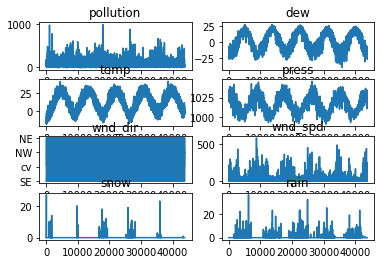

In [4]:
columns = dataset.columns
fig, axis = pyplot.subplots(4, 2)

axis[0,0].set_title(columns[0])
axis[0,0].plot(values[:,0])

axis[0,1].set_title(columns[1])
axis[0,1].plot(values[:,1])

axis[1,0].set_title(columns[2])
axis[1,0].plot(values[:,2])

axis[1,1].set_title(columns[3])
axis[1,1].plot(values[:,3])

axis[2,0].set_title(columns[4])
axis[2,0].plot(values[:,4])

axis[2,1].set_title(columns[5])
axis[2,1].plot(values[:,5])

axis[3,0].set_title(columns[6])
axis[3,0].plot(values[:,6])

axis[3,1].set_title(columns[7])
axis[3,1].plot(values[:,7])

## Plot Data
Plot the data and get a figure similar to Fig.1 
<img src="images/f1.png" style="width:350px;height:250px;">
<caption><center> **Fig. 1** : ** Pollution & Weather Time series dataset** </center></caption>

## LSTM Data Preparation
Prepare the dataset for the LSTM, that is, frame the dataset as a supervised learning problem to predict the pollution (pm2.5) at the current or future hours given the past pollution and weather conditions over a number of prior time steps (hours).


**Original data frame (each row has data of only that hour)** :

row 1=> var1(t), var2(t),...var8(t)

row 2=> var1(t-1), var2(t-1),...var8(t)

row 3=> .....

**After series_to_supervised (each row has data of n previous hours and the current hour)**:


row 1=> var1(t-n), var2(t-n),...var8(t-n), var1(t-n+1), var2(t-n+1),...var8(t-n+1), .....var1(t), var3(t),...var8(t)

row 2=> var1(t-n-1), var2(t-n-1),...var8(t-n-1), var1(t-1), var3(t-1),...var8(t-1)

row 3 => ...




In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    """
        data: data matrix
        n_in: number of input lag timesteps (hours)
        n_out: number of output prediction timesteps (hours)
 
    """
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)  #transforms data (pure matrix of values) into data structure adding index of rows and columns
    cols, names = list(), list()  #inicialize empty lists 
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [6]:
# encode the categorical feature cbwd: Combined wind direction (4 categorical values) into integers (0,1,2,3)
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) # transform the 5th column into integers 0,1,2,3

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)  #apply scaler to the values 

# specify the number of lag hours. You can change this hyper-parameter
n_hours = 3

# call series_to_supervised to frame data as supervised learning
reframed = series_to_supervised(scaled, n_in=n_hours)

print("Before drop set")
print(reframed.head(3))

# we want to predict only the feature pm2.5 =var1(t)
# Take out the columns of var2(t), var3(t),...var8(t). The indexes below are correct if n_hours = 3
reframed.drop(reframed.columns[[31, 30, 29, 28, 27, 26, 25]], axis=1, inplace=True)

# Observe the difference before and after the drop step 
print("\nAfter drop set")
print(reframed.head(3))


Before drop set
   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var7(t-1)  var8(t-1)  \
3        0.0        0.0   0.148893   0.367647  ...   0.000000        0.0   
4        0.0        0.0   0.159960   0.426471  ...   0.037037        0.0   
5        0.0        0.0   0.182093   0.485294  ...   0.074074        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
3  0.182093  0.485294  0.229508  0.563637  0.666667  0.008391  0.037037   
4  0.138833  0.485294  0.229508  0.563637  0.666667  0.009912  0.074074   
5  0.109658  0.485294  0.213115  0.563637  0.666667  0.011433  0.111111   

   var8(t)  
3      0.0  
4      0.0  
5      0.0  

[3 rows x 32 columns]

After drop set
  

## Split Data

First, data is split into train and test subsets. To speed up the model fiting, the training data is only the 
1st year, the test data are the remaining 4 years. You may consider exploring the oposite. 

Then the train and test sets are split into input and output variables. 

Finally, the inputs (X) are reshaped into 3D format expected by LSTMs, namely [samples, timesteps, features].

**Total data**: 43800 samples (5 years x 365 days x 24 hours), 8 features.

**Train data**: 3D tensor(samples, timesteps, features).
8760 samples:  Data from 1 year (365 days), 24 times per day (1h period).

**Test data**: 3D tensor (samples, timesteps, features). The rest of 35037 samples. 

In [8]:
# split into train and test sets

# reframed is a structure that has not only values but also heads and row indixes. Extract only the values 
values = reframed.values
n_train_hours = 365 * 24 * n_hours  #8760 (1 year, 24 times per day, i.e. period 1h)

#Extract training subset from values 
train = values[:n_train_hours, :]
print(train.shape)

#Extract test subset from values 
test = values[n_train_hours:, :]
print(test.shape)

# split into input and outputs

n_features = 8  #number of features
n_obs = n_hours * n_features  # 3*8 =24

train_X  = train[:, :-1]    # train_X.shape = (8760, 24)
train_y = train[:, -1]      # train_y.shape = (8760,)

test_X  = test[:, :-1]      # test_X.shape = (35037, 24)
test_y = test[:, -1]        # test_y.shape = (35037,)

# reshape input to be 3D [samples, lag_hours, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features)) # train_X.shape=(8760,3,8)
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))  # test_X.shape=(35037,3,8)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 25)
(17517, 25)
(26280, 3, 8) (26280,) (17517, 3, 8) (17517,)


## Define and Fit Model

In this section, we define and fit an LSTM on the multivariate input data.
We define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution.
We use the Mean Absolute Error (MAE) loss function and the Adam version of stochastic gradient descent.
The model will be fit for 50 training epochs with a batch size of 72. 
At the end of the run both the training and test loss are plotted.

Epoch 1/50
365/365 - 2s - loss: 0.0324 - val_loss: 0.0212 - 2s/epoch - 7ms/step
Epoch 2/50
365/365 - 1s - loss: 0.0194 - val_loss: 0.0199 - 906ms/epoch - 2ms/step
Epoch 3/50
365/365 - 1s - loss: 0.0185 - val_loss: 0.0183 - 885ms/epoch - 2ms/step
Epoch 4/50
365/365 - 1s - loss: 0.0174 - val_loss: 0.0169 - 905ms/epoch - 2ms/step
Epoch 5/50
365/365 - 1s - loss: 0.0161 - val_loss: 0.0156 - 894ms/epoch - 2ms/step
Epoch 6/50
365/365 - 1s - loss: 0.0148 - val_loss: 0.0141 - 916ms/epoch - 3ms/step
Epoch 7/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0137 - 963ms/epoch - 3ms/step
Epoch 8/50
365/365 - 1s - loss: 0.0137 - val_loss: 0.0139 - 875ms/epoch - 2ms/step
Epoch 9/50
365/365 - 1s - loss: 0.0138 - val_loss: 0.0137 - 988ms/epoch - 3ms/step
Epoch 10/50
365/365 - 1s - loss: 0.0137 - val_loss: 0.0137 - 896ms/epoch - 2ms/step
Epoch 11/50
365/365 - 1s - loss: 0.0138 - val_loss: 0.0139 - 899ms/epoch - 2ms/step
Epoch 12/50
365/365 - 1s - loss: 0.0137 - val_loss: 0.0138 - 1s/epoch - 3ms/step
Epoch 1

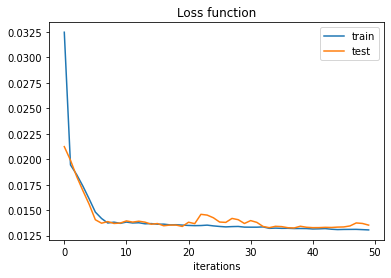

In [9]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
# neurons =50
# single input_shape = (lag_hours, feature)
model.add( LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])) )
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mae', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#  print history
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Loss function')
pyplot.legend(['train', 'test'])
pyplot.xlabel('iterations')
pyplot.show()
 

## Evaluate Model
After the model is fit, we can forecast for the test dataset.
Compute the error as the Root Mean Squared Error (RMSE). 

Compare the predictions and the real data as shown in Fig. 2. 

<img src="images/f2.png" style="width:350px;height:250px;">
<caption><center> **Fig. 1** : ** Test data prediction (the first 2000 samples)** </center></caption>

Test RMSE: 0.027


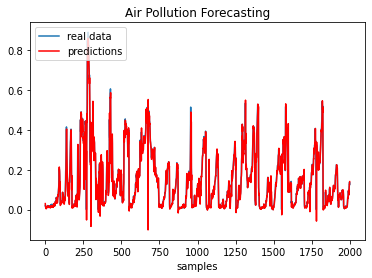

In [12]:
yhat = model.predict(test_X) 

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)     

#Plot test_y and yhat on the same plot
#use pyplot from matplotlib

pyplot.title('Air Pollution Forecasting')
pyplot.xlabel('samples')
pyplot.plot(test_y[:2000], label='real data')
pyplot.plot(yhat[:2000], label='predictions', color='r')
pyplot.legend(loc='upper left')


Test RMSE: 0.027


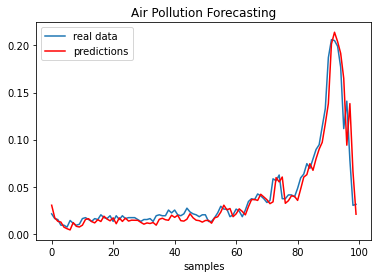

In [13]:
yhat = model.predict(test_X) 

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)     

#Plot test_y and yhat on the same plot
#use pyplot from matplotlib

pyplot.title('Air Pollution Forecasting')
pyplot.xlabel('samples')
pyplot.plot(test_y[:100], label='real data')
pyplot.plot(yhat[:100], label='predictions', color='r')
pyplot.legend(loc='upper left')
